In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
# Declare a Base using `automap_base()`
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
stations = Base.classes.station

In [8]:
dir(measurement)
# 'classes',
# 'date',
# 'id',
# 'metadata',
# 'prcp',
# 'prepare',
# 'station',
# 'tobs'

dir(stations)
# 'classes',
# 'elevation',
# 'id',
# 'latitude',
# 'longitude',
# 'metadata',
# 'name',
# 'prepare',
# 'station'


['__abstract__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__mapper__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__table__',
 '__weakref__',
 '_decl_class_registry',
 '_sa_class_manager',
 '_sa_decl_prepare',
 '_sa_raise_deferred_config',
 'classes',
 'elevation',
 'id',
 'latitude',
 'longitude',
 'metadata',
 'name',
 'prepare',
 'station']

In [9]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Check where can we find precipitation data
# session.query(measurement.prcp).all()

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# query the date 1 year ago from the last data point in the database
last_date_query = session.query(measurement.date).\
                        order_by(measurement.date.desc()).first()

last_date = last_date_query[0]

#https://stackabuse.com/converting-strings-to-datetime-in-python/
last_date_dt = dt.datetime.strptime(last_date, '%Y-%m-%d')
date_1yr_ago = last_date_dt - dt.timedelta(days=365) 


print(f"The last date in the table was {last_date_dt.date()}.\n The date one year from the last date was {date_1yr_ago.date()}")

The last date in the table was 2017-08-23.
 The date one year from the last date was 2016-08-23


In [14]:
# Perform a query to retrieve the date and precipitation scores for the last 12 months of data

sel = [measurement.date, measurement.prcp]

year_rainfall = session.query(*sel).\
                    filter(measurement.date >= date_1yr_ago).\
                        order_by(measurement.date).all()

# year_rainfall

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(year_rainfall, columns=['Date', 'Precipitaton'])
df

,Date,Precipitaton
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22
...,...,...
2218,2017-08-22,0.50
2219,2017-08-23,0.00
2220,2017-08-23,0.00
2221,2017-08-23,0.08


In [16]:
# Sort the dataframe by date and drop any NaN
df = df.sort_values(by='Date', ascending=True)
df = df.set_index('Date')
#df = df.dropna(how='any')
df


,Precipitaton
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


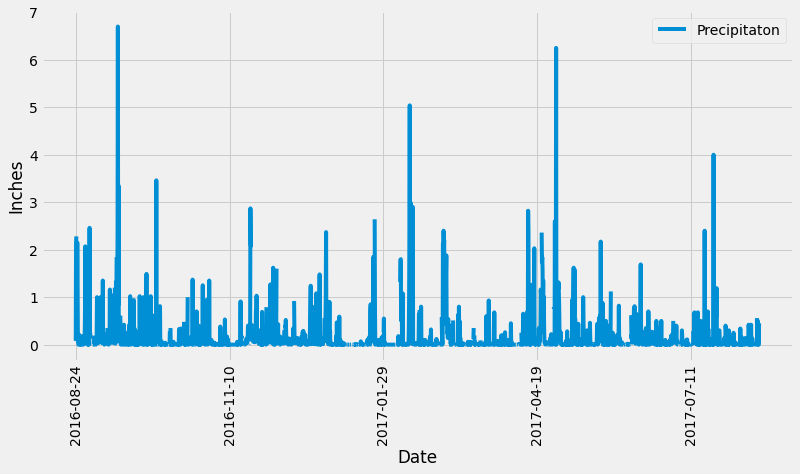

In [17]:
# Plot the dataframe

df.plot(figsize=(12,6))
plt.xticks(rotation=90)
plt.ylabel('Inches')
plt.show()

In [18]:
# Calcualte the summary statistics for the precipitation data

df.describe()

,Precipitaton
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(stations.station)).all()

[(9)]

In [20]:
# check that station count has no duplicates 
session.query(func.count(stations.id)).all()

[(9)]

In [21]:
# use distinct to count only uniques
stationcount = session.query(func.count(distinct(stations.station))).all()
stationcount

[(9)]

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

sel = [measurement.station, 
       func.count(measurement.prcp)]

station_counts = session.query(*sel).\
                   group_by(measurement.station).\
                    order_by(func.count(measurement.prcp).desc()).all()
   
station_counts

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 

# assign most active station from query
most_active = station_counts[0][0]

# query the database
sel = [measurement.station, 
        func.min(measurement.tobs),
         func.max(measurement.tobs),
          func.avg(measurement.tobs)
        ]

summary_station = session.query(*sel).\
                   filter(measurement.station == most_active).all()

# assign query results 
lowest_temp = summary_station[0][1]
highest_temp = summary_station[0][2]
avg_temp = summary_station[0][3]

print(f'The lowest temp found for station {most_active} was {lowest_temp}')
print(f'The highest temp found for station {most_active} was {highest_temp}')
print(f'The average temp found for station {most_active} was {round(avg_temp, 2)}')

The lowest temp found for station USC00519281 was 54.0
The highest temp found for station USC00519281 was 85.0
The average temp found for station USC00519281 was 71.66


In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

sel = [measurement.date,
         measurement.tobs
        ]

station_query = session.query(*sel).\
                   filter(measurement.station == most_active).\
                    filter(measurement.date >= date_1yr_ago).\
                    order_by(measurement.date.desc()).all()
# station_query


In [25]:
# make a data frame for plotting wth query results and clean the results
station_query_df = pd.DataFrame(station_query) 
station_query_df = station_query_df.sort_values(by='date', ascending=True)
station_query_df = station_query_df.set_index('date')
station_query_df = station_query_df.dropna(how='any')
station_query_df

,tobs
date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


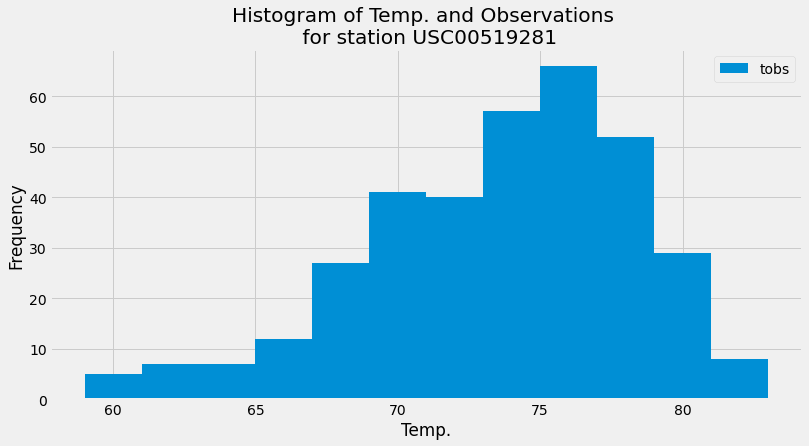

In [26]:
# plot Histogram of results
station_query_df.plot.hist('tobs', bins = 12, figsize=(12,6))
plt.xlabel('Temp.')
plt.ylabel('Frequency')
plt.title(f'Histogram of Temp. and Observations \n for station {most_active}')
plt.show()

## Bonus Challenge Assignment

In [27]:
# This function accepts start date and end date in the format '%Y-%m-%d' 
# and returns the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# TEST
end_date = last_date
start_date = date_1yr_ago.strftime('%Y-%m-%d')
print(calc_temps(start_date, end_date))

[(58.0, 74.59058295964125, 87.0)]


In [29]:
# for a trip using the previous year's data for those same dates. 
# the trip dates
end = '2017-07-27'
start = '2017-07-14'

# year ago from trip
start_1yr_ago = dt.datetime.strptime(start, '%Y-%m-%d') - dt.timedelta(days=365)
end_1yer_ago = dt.datetime.strptime(end, '%Y-%m-%d') - dt.timedelta(days=365)

results = calc_temps(start_1yr_ago, end_1yer_ago)
minimum = results[0][0]
maximum = results[0][2]
avg = results[0][1]

#print(calc_temps(start_1yr_ago, end_1yer_ago))
print(f'For a trip during {start_1yr_ago.date()} to {end_1yer_ago.date()} the minimum temperature (F) was {minimum}, \nmaximum {maximum} and average {round(avg,2)}' )

For a trip during 2016-07-14 to 2016-07-27 the minimum temperature (F) was 71.0, 
maximum 83.0 and average 77.77


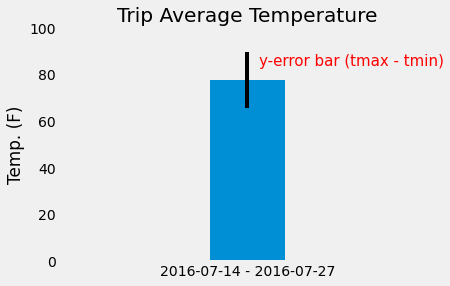

In [30]:
# Plot the results from previous query for a year ago as a bar chart. 
x_value = {start_1yr_ago, end_1yer_ago}
y_value = avg
yerr =  maximum - minimum

plt.bar(f'{start_1yr_ago.date()} - {end_1yer_ago.date()}', y_value, yerr = yerr)
plt.annotate('y-error bar (tmax - tmin)', (0.12, 84), fontsize = 15, color="red")
plt.xlim(-2, 2)
plt.ylim(0,100)
plt.title("Trip Average Temperature")
plt.ylabel("Temp. (F)")
plt.grid()
plt.show()

# Used the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

In [31]:
# query total amount of rainfall per weather station for trip dates using the previous year's matching dates.

sel = ([stations.station, stations.name, func.sum(measurement.prcp), 
            stations.latitude, stations.longitude, stations.elevation
       ])

result = session.query(*sel).filter(stations.station == measurement.station).\
            filter(measurement.date >= start_1yr_ago).\
                filter(measurement.date <= end_1yer_ago).\
                    group_by(stations.station).\
                        order_by(func.sum(measurement.prcp).desc()).all() 

# put in a dataframe for easier viewing
print(f'Total rainfall per station for {start_1yr_ago.date()} - {end_1yer_ago.date()}' )
rainfall_station = pd.DataFrame(result, columns=["Station", "Station Name", "Total Precipitation (inches)", "Latitude", "Longitude", "Elevation"])
rainfall_station = rainfall_station.set_index('Station')
rainfall_station

Total rainfall per station for 2016-07-14 - 2016-07-27


,Station Name,Total Precipitation (inches),Latitude,Longitude,Elevation
Station,,,,,
USC00519281,"WAIHEE 837.5, HI US",13.45,21.45167,-157.84889,32.9
USC00516128,"MANOA LYON ARBO 785.2, HI US",13.19,21.33310,-157.80250,152.4
USC00513117,"KANEOHE 838.1, HI US",9.12,21.42340,-157.80150,14.6
USC00519397,"WAIKIKI 717.2, HI US",6.16,21.27160,-157.81680,3.0
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",4.38,21.33556,-157.71139,19.5
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1.51,21.52130,-157.83740,7.0
USC00517948,"PEARL CITY, HI US",0.51,21.39340,-157.97510,11.9


In [32]:
# query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day regardless of year)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# TEST
# startplusone = dt.datetime.strptime(start, '%Y-%m-%d') + dt.timedelta(days=1)
# startplusone 

In [46]:
# calculate the daily normals for the trip
# set dates for trip
end = '2017-07-27'
start = '2017-07-14'

end_date = dt.datetime.strptime(end, '%Y-%m-%d')
start_date = dt.datetime.strptime(start, '%Y-%m-%d')

# the number of days for the trip
no_days = (end_date - start_date).days + 1
no_days

14

In [47]:
# loop and find all dates in the trip
date_range = []
for x in range(no_days):
    date_range.append(start_date + dt.timedelta(days=x))                            
date_range

[datetime.datetime(2017, 7, 14, 0, 0),
 datetime.datetime(2017, 7, 15, 0, 0),
 datetime.datetime(2017, 7, 16, 0, 0),
 datetime.datetime(2017, 7, 17, 0, 0),
 datetime.datetime(2017, 7, 18, 0, 0),
 datetime.datetime(2017, 7, 19, 0, 0),
 datetime.datetime(2017, 7, 20, 0, 0),
 datetime.datetime(2017, 7, 21, 0, 0),
 datetime.datetime(2017, 7, 22, 0, 0),
 datetime.datetime(2017, 7, 23, 0, 0),
 datetime.datetime(2017, 7, 24, 0, 0),
 datetime.datetime(2017, 7, 25, 0, 0),
 datetime.datetime(2017, 7, 26, 0, 0),
 datetime.datetime(2017, 7, 27, 0, 0)]

In [36]:
# strip the year off and append to a list
month_day = []
for y in range(len(date_range)):
    month_day.append(date_range[y].strftime("%m-%d"))
month_day

['07-14',
 '07-15',
 '07-16',
 '07-17',
 '07-18',
 '07-19',
 '07-20',
 '07-21',
 '07-22',
 '07-23',
 '07-24',
 '07-25',
 '07-26',
 '07-27']

In [37]:
# Loop through the list of %m-%d strings and calculate the normals for each date
min = []
avg = []
max = []
for z in month_day:
    min.append(daily_normals(z)[0][0])
    avg.append(daily_normals(z)[0][1])
    max.append(daily_normals(z)[0][2])

In [38]:
# create a dataframe with all results for each date
df = pd.DataFrame()
df['Date'] = month_day
df['Temp. min.'] = min
df['Temp. avg.'] = avg
df['Temp. max.'] = max
df = df.set_index('Date')
df

,Temp. min.,Temp. avg.,Temp. max.
Date,,,
07-14,61.0,76.228070,82.0
07-15,68.0,76.254237,82.0
07-16,70.0,76.344828,83.0
07-17,70.0,76.301887,83.0
07-18,72.0,76.637931,83.0
07-19,68.0,75.890909,83.0
07-20,69.0,75.462963,82.0
07-21,69.0,76.924528,83.0
07-22,69.0,75.788462,81.0


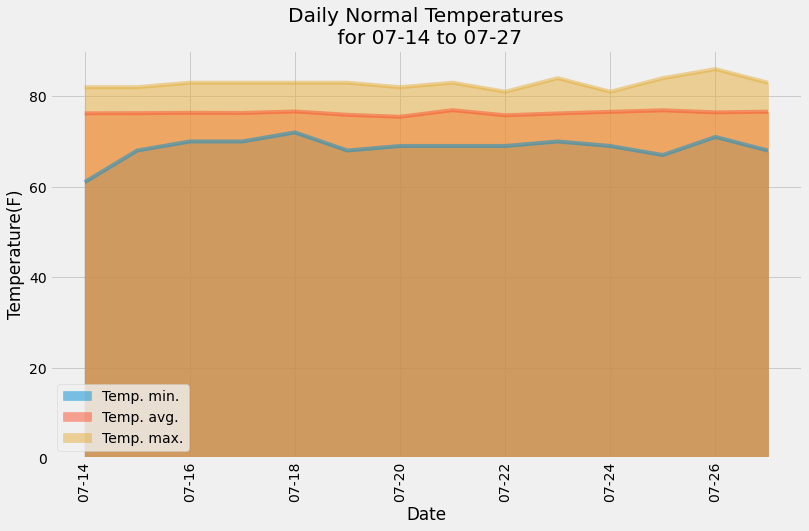

In [43]:
# Plot the daily normals as an area plot
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.area.html
df.plot.area(figsize=(12, 7), rot=90, stacked=False, alpha = 0.5)
plt.ylabel("Date")
plt.ylabel("Temperature(F)")
plt.title(f"Daily Normal Temperatures\n for {month_day[0]} to {month_day[-1]}")
plt.show()